In [1]:
import os
import glob

# First of all, we need some satellite data. 
# Let's open a lightweight a Landsat-5 MSS collection 2 tile.
path = os.path.join("/home", "data", "DATA", "PRODS", "LANDSATS_COL2", "LM05_L1TP_200029_19841014_20200902_02_T2.tar")

In [2]:
from eoreader.reader import Reader

# Create the reader
eoreader = Reader()

# This reader is a singleton can be called once and then open all your data.
# Use it like a logging.getLogger() instance

In [3]:
from eoreader.bands.alias import *

# Open your product
prod = eoreader.open(path, remove_tmp=True) # No need to unzip here
print(prod)

In [4]:
# Here you have opened your product and you have its object in hands
# You can play a little with it to see what it got inside
print(f"Landsat tile: {prod.tile_name}")
print(f"Acquisition datetime: {prod.datetime}")

Landsat tile: 200029
Acquisition datetime: 1984-10-14 10:18:17


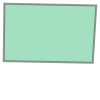

In [5]:
# Open here some more interesting geographical data: extent
extent = prod.extent()
extent.geometry.to_crs("EPSG:4326").iat[0]  # Display

make_valid not available in shapely (version 1.7.1 < 1.8). The obtained vector may be broken !


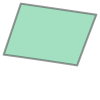

In [6]:
# Open here some more interesting geographical data: footprint
footprint = prod.footprint()
footprint.geometry.to_crs("EPSG:4326").iat[0]  # Display

In [7]:
from eoreader.env_vars import DEM_PATH
# Select the bands you want to load
bands = [GREEN, NDVI, TIR_1, CLOUDS, SHADOWS]

# Compute DEM band only if you have set a DEM in your environment path
if DEM_PATH in os.environ:
    bands.append(HILLSHADE)

# Be sure they exist for Landsat-5 MSS sensor:
ok_bands = [band for band in bands if prod.has_band(band)]
print(to_str(ok_bands)) # Landsat-5 MSS doesn't provide TIR and SHADOWS bands

['GREEN', 'NDVI', 'CLOUDS']


In [8]:
# Load those bands as a dict of xarray.DataArray
band_dict = prod.load(ok_bands)
band_dict[GREEN]

<xarray.DataArray 'GREEN' (band: 1, y: 3473, x: 3909)>
dask.array<where, shape=(1, 3473, 3909), dtype=float32, chunksize=(1, 3473, 3909), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 5.549e+05 5.55e+05 ... 7.894e+05 7.894e+05
  * y            (y) float64 5.049e+06 5.049e+06 ... 4.841e+06 4.841e+06
    spatial_ref  int64 0
Attributes:
    long_name:  GREEN

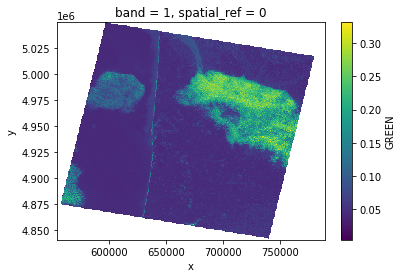

In [9]:
# The nan corresponds to the nodata you see on the footprint
%matplotlib inline

# Plot a subsampled version
band_dict[GREEN][:, ::10, ::10].plot()

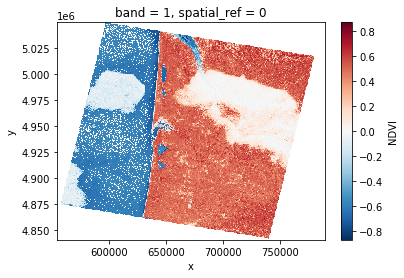

In [10]:
# Plot a subsampled version
band_dict[NDVI][:, ::10, ::10].plot()

In [11]:
# Plot a subsampled version
if HILLSHADE in band_dict:
    band_dict[HILLSHADE][:, ::10, ::10].plot()

In [12]:
# You can also stack those bands
stack = prod.stack(ok_bands)
stack

<xarray.DataArray 'NDVI_GREEN_CLOUDS' (z: 3, y: 3473, x: 3909)>
dask.array<astype, shape=(3, 3473, 3909), dtype=float32, chunksize=(1, 3473, 3909), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 5.549e+05 5.55e+05 ... 7.894e+05 7.894e+05
  * y            (y) float64 5.049e+06 5.049e+06 ... 4.841e+06 4.841e+06
  * z            (z) MultiIndex
  - variable     (z) object 'NDVI' 'GREEN' 'CLOUDS'
  - band         (z) int64 1 1 1
Attributes:
    long_name:  ['NDVI', 'GREEN', 'CLOUDS']

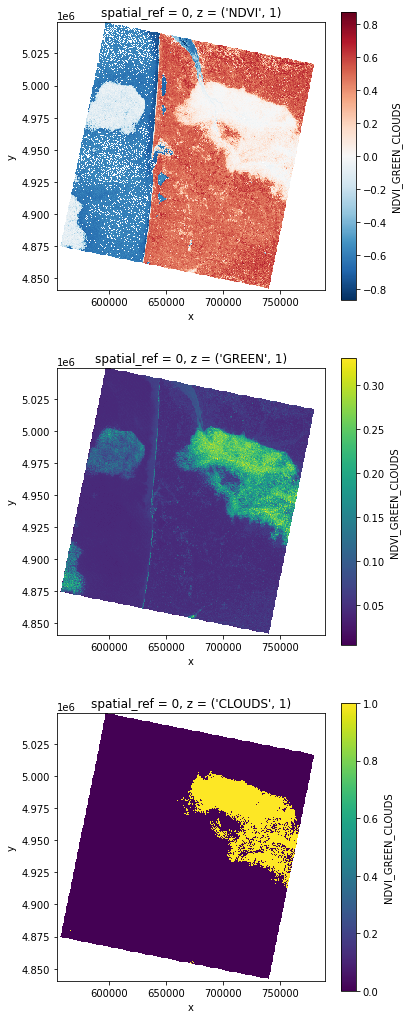

In [13]:
# Error in plotting with a list
if "long_name" in stack.attrs:
    stack.attrs.pop("long_name")

# Plot a subsampled version
import matplotlib.pyplot as plt
nrows = len(stack)
fig, axes = plt.subplots(nrows=nrows, figsize=(2*nrows, 6*nrows), subplot_kw={"box_aspect": 1})  # Square plots
for i in range(nrows):
    stack[i, ::10, ::10].plot(x="x", y="y", ax=axes[i])
